# Model Define

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda, Input, GlobalAveragePooling1D
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [17]:
class Custom_Model() :
    def __init__(self, weight, input_shape) :
        self.checkpoint = weight
        self.model = self.build_model(input_shape)
        
    def build_model(self, input_shape : tuple):
        input = Input(shape=input_shape)
        x = LSTM(128, return_sequences=True, activation='tanh', dropout=0.2)(input)
        x = LSTM(64, return_sequences=True, activation='tanh', dropout=0.2)(x)
        x = LSTM(32, return_sequences=True, activation='tanh', dropout=0.2)(x)
        x = GlobalAveragePooling1D()(x)
        output = Dense(1)(x)
        return Model(input, output)
        
    
    def load_model(self) :
        self.model.load_weights(self.checkpoint)
        return self.model


In [18]:
window_size = 6
n_feature = 6

weight = './checkpoints/ckeckpointer.ckpt'
input_shape = (window_size, n_feature)

model = Custom_Model(weight, input_shape)
lstm_model = model.load_model()
lstm_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6, 6)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 6, 128)            69120     
_________________________________________________________________
lstm_1 (LSTM)                (None, 6, 64)             49408     
_________________________________________________________________
lstm_2 (LSTM)                (None, 6, 32)             12416     
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 130,977
Trainable params: 130,977
Non-trainable params: 0
_______________________________________________________

# Inference Data Preprocess

In [19]:
import pandas as pd
import os
from glob import glob
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import pyupbit

In [66]:
class Data_preprocess() :
    def __init__(self, ticker, interval, to, count) :
        self.data, self.label, self.dataset = self.preprocess(pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count))
    
    def MinMax(self, dataset_df) :
        norm = MinMaxScaler()
        norm_dataset = norm.fit_transform(dataset_df)
        return pd.DataFrame(norm_dataset, columns=list(dataset_df.columns))
    
    
    def add_after10(self, dataset_df) :
        after10 = np.zeros_like(self.norm_dataset['close'])
        for i in range(len(dataset_df['close']) - 1) :
            after10[i] = dataset_df['close'][i + 1]
        return after10
    
    
    def drop_feature(self, dataset_df) :
        # index(시간) 제거
        dataset_df = dataset_df.reset_index(drop=True)
        # value 제거
        dataset_df = dataset_df.drop(columns=['value'])
        return dataset_df
    
    
    def add_avgPrice(self, dataset_df) :
        return (dataset_df['high'] + dataset_df['low'] + 
                dataset_df['open'] + dataset_df['close']) // 4
       
    
    def preprocess(self, dataset, latest=False) :
        
        # drop feature
        dataset_df = self.drop_feature(dataset)
        
        # avg_price 추가
        dataset_df['avg_price'] = self.add_avgPrice(dataset_df)
        
        if latest == True :
            # 가장 예전 데이터 삭제 - norm이랑 original 둘 다 적용
            self.dataset = self.dataset.drop([self.dataset.index[0]]).drop(columns=['after10'])
            self.norm_dataset = self.norm_dataset.drop([self.norm_dataset.index[0]])

            # ori dataset에 추가
            self.dataset = pd.concat([self.dataset, dataset_df])
            self.dataset = self.dataset.reset_index(drop=True)
            
            # min max 정규화 (MinMaxScaler) 적용
            self.norm_dataset = self.MinMax(self.dataset)
            
            # after10 추가
            self.dataset['after10'] = self.add_after10(self.dataset)
            
        
        else :
            # min max 정규화 (MinMaxScaler) 적용
            self.norm_dataset = self.MinMax(dataset_df)
            
            # after10 추가
            dataset_df['after10'] = self.add_after10(dataset_df)
        
        # 예측될 값(label)인 10분 후 가격
        self.norm_dataset['after10'] = self.add_after10(self.norm_dataset)

        return self.norm_dataset.drop(columns=['after10']), self.norm_dataset['after10'], dataset_df
        
    
        
    # dataset에 window 적용
    def windowed_dataset(self, window_size, batch_size) :
        sliced_data = tf.data.Dataset.from_tensor_slices(self.data)
        sliced_data = sliced_data.window(window_size, shift=1, stride=1, drop_remainder=True)
        sliced_data = sliced_data.flat_map(lambda x : x.batch(window_size))
        
        sliced_label = tf.data.Dataset.from_tensor_slices(self.label[window_size:])
        
        sliced_dataset = tf.data.Dataset.zip((sliced_data, sliced_label))
        
        return sliced_dataset.batch(batch_size).prefetch(1)
    

        
        

In [67]:
ticker = 'KRW-BTC'
interval ='minute10'
to = f'2021-11-10 00:10'
count = 1000

window_size = 6
batch_size = 1

processed_data =  Data_preprocess(ticker, interval, to, count)
dataset = processed_data.windowed_dataset(window_size, batch_size)


for data in dataset.take(1):
    print("Data ==> ")
    print(data[0])
    
    print("\nLabel ==> ")
    print(data[1])
    
print(processed_data.dataset)
print(processed_data.norm_dataset)

Data ==> 
tf.Tensor(
[[[0.22419028 0.21817058 0.23657237 0.203964   0.12238874 0.21419267]
  [0.2041498  0.20220437 0.23677737 0.20993023 0.07456903 0.20658573]
  [0.21012146 0.2092089  0.24446494 0.21266053 0.07799429 0.21255145]
  [0.21295547 0.20879687 0.24395244 0.21963798 0.0829506  0.21484395]
  [0.21973684 0.20488257 0.22539975 0.19445849 0.06683506 0.20439744]
  [0.19463563 0.1894314  0.20110701 0.17382951 0.11533618 0.18254051]]], shape=(1, 6, 6), dtype=float64)

Label ==> 
tf.Tensor([0.16988573], shape=(1,), dtype=float64)
           open        high         low       close      volume   avg_price  \
0    75025000.0  75110000.0  74808000.0  74827000.0   42.323616  74942500.0   
1    74827000.0  74955000.0  74810000.0  74886000.0   26.774901  74869500.0   
2    74886000.0  75023000.0  74885000.0  74913000.0   27.888634  74926750.0   
3    74914000.0  75019000.0  74880000.0  74982000.0   29.500190  74948750.0   
4    74981000.0  74981000.0  74699000.0  74733000.0   24.260177  7

In [68]:
pred = lstm_model.predict(dataset)
actual = np.asarray(processed_data.label)[6:]

pred = pred[:, 0]

print(pred.shape)
print(actual.shape)

(994,)
(994,)


# Data Parsing every 10 min
# Delete First Line and add latest data at last line  

### LIKE A QUEUE

In [69]:
# 현재 시간 문자열로 가져오기
import datetime
now = datetime.datetime.now()
str_now = now.strftime('%Y-%m-%d %H:%M')
print(type(str_now))
print(str_now)

<class 'str'>
2021-11-13 17:35


In [86]:
current_t = str(datetime.datetime.now())
current_t

'2021-11-13 19:03:20.783025'

In [70]:
# 다음 10분 찾기
import datetime
current_t = datetime.datetime.now()
remainder_min = 10 - current_t.minute % 10

print(remainder_min)
print("현재 시간 : ", current_t)

coming_10m = current_t + datetime.timedelta(minutes=int(remainder_min))
print("다음 10분 : ",coming_10m)

5
현재 시간 :  2021-11-13 17:35:56.296619
다음 10분 :  2021-11-13 17:40:56.296619


In [71]:
import pyupbit
import pandas as pd

ticker = 'KRW-BTC'
interval ='minute10'
to = coming_10m
count = 1

latest_data = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
latest_data

,open,high,low,close,volume,value
2021-11-13 17:30:00,77599000.0,77682000.0,77553000.0,77599000.0,12.302363,9.546723e+08


In [72]:
processed_data.dataset

,open,high,low,close,volume,avg_price,after10
0,75025000.0,75110000.0,74808000.0,74827000.0,42.323616,74942500.0,74886000.0
1,74827000.0,74955000.0,74810000.0,74886000.0,26.774901,74869500.0,74913000.0
2,74886000.0,75023000.0,74885000.0,74913000.0,27.888634,74926750.0,74982000.0
3,74914000.0,75019000.0,74880000.0,74982000.0,29.500190,74948750.0,74733000.0
4,74981000.0,74981000.0,74699000.0,74733000.0,24.260177,74848500.0,74529000.0
...,...,...,...,...,...,...,...
995,81359000.0,81359000.0,81166000.0,81203000.0,54.985089,81271750.0,81118000.0
996,81203000.0,81265000.0,81080000.0,81118000.0,46.954699,81166500.0,80776000.0
997,81118000.0,81385000.0,80756000.0,80776000.0,60.260760,81008750.0,80650000.0
998,80776000.0,80999000.0,80550000.0,80650000.0,99.310089,80743750.0,80441000.0


In [73]:
processed_data.norm_dataset

,open,high,low,close,volume,avg_price,after10
0,0.224190,0.218171,0.236572,0.203964,0.122389,0.214193,0.209930
1,0.204150,0.202204,0.236777,0.209930,0.074569,0.206586,0.212661
2,0.210121,0.209209,0.244465,0.212661,0.077994,0.212551,0.219638
3,0.212955,0.208797,0.243952,0.219638,0.082951,0.214844,0.194458
4,0.219737,0.204883,0.225400,0.194458,0.066835,0.204397,0.173830
...,...,...,...,...,...,...,...
995,0.865283,0.861867,0.888274,0.848721,0.161329,0.873730,0.840125
996,0.849494,0.852184,0.879459,0.840125,0.136632,0.862762,0.805542
997,0.840891,0.864545,0.846248,0.805542,0.177554,0.846324,0.792800
998,0.806275,0.824784,0.825133,0.792800,0.297649,0.818710,0.771665


# 새로운 데이터 추가 및 적용

In [74]:
_,_,_ = processed_data.preprocess(latest_data, latest=True)

In [75]:
processed_data.dataset

,open,high,low,close,volume,avg_price,after10
0,74827000.0,74955000.0,74810000.0,74886000.0,26.774901,74869500.0,74913000.0
1,74886000.0,75023000.0,74885000.0,74913000.0,27.888634,74926750.0,74982000.0
2,74914000.0,75019000.0,74880000.0,74982000.0,29.500190,74948750.0,74733000.0
3,74981000.0,74981000.0,74699000.0,74733000.0,24.260177,74848500.0,74529000.0
4,74733000.0,74831000.0,74462000.0,74529000.0,40.030457,74638750.0,74571000.0
...,...,...,...,...,...,...,...
995,81203000.0,81265000.0,81080000.0,81118000.0,46.954699,81166500.0,80776000.0
996,81118000.0,81385000.0,80756000.0,80776000.0,60.260760,81008750.0,80650000.0
997,80776000.0,80999000.0,80550000.0,80650000.0,99.310089,80743750.0,80441000.0
998,80650000.0,80688000.0,80277000.0,80441000.0,167.911427,80514000.0,77599000.0


In [76]:
processed_data.norm_dataset

,open,high,low,close,volume,avg_price,after10
0,0.204150,0.202204,0.236777,0.209930,0.074569,0.206586,0.212661
1,0.210121,0.209209,0.244465,0.212661,0.077994,0.212551,0.219638
2,0.212955,0.208797,0.243952,0.219638,0.082951,0.214844,0.194458
3,0.219737,0.204883,0.225400,0.194458,0.066835,0.204397,0.173830
4,0.194636,0.189431,0.201107,0.173830,0.115336,0.182541,0.178077
...,...,...,...,...,...,...,...
995,0.849494,0.852184,0.879459,0.840125,0.136632,0.862762,0.805542
996,0.840891,0.864545,0.846248,0.805542,0.177554,0.846324,0.792800
997,0.806275,0.824784,0.825133,0.792800,0.297649,0.818710,0.771665
998,0.793522,0.792748,0.797150,0.771665,0.508631,0.794769,0.484275


# 추가한 데이터셋으로 다시 inference 

In [77]:
dataset = processed_data.windowed_dataset(window_size, batch_size)

for data in dataset.take(1):
    print("Data ==> ")
    print(data[0])
    
    print("\nLabel ==> ")
    print(data[1])
    
print(processed_data.dataset)
print(processed_data.norm_dataset)

Data ==> 
tf.Tensor(
[[[0.22419028 0.21817058 0.23657237 0.203964   0.12238874 0.21419267]
  [0.2041498  0.20220437 0.23677737 0.20993023 0.07456903 0.20658573]
  [0.21012146 0.2092089  0.24446494 0.21266053 0.07799429 0.21255145]
  [0.21295547 0.20879687 0.24395244 0.21963798 0.0829506  0.21484395]
  [0.21973684 0.20488257 0.22539975 0.19445849 0.06683506 0.20439744]
  [0.19463563 0.1894314  0.20110701 0.17382951 0.11533618 0.18254051]]], shape=(1, 6, 6), dtype=float64)

Label ==> 
tf.Tensor([0.16988573], shape=(1,), dtype=float64)
           open        high         low       close      volume   avg_price  \
0    74827000.0  74955000.0  74810000.0  74886000.0   26.774901  74869500.0   
1    74886000.0  75023000.0  74885000.0  74913000.0   27.888634  74926750.0   
2    74914000.0  75019000.0  74880000.0  74982000.0   29.500190  74948750.0   
3    74981000.0  74981000.0  74699000.0  74733000.0   24.260177  74848500.0   
4    74733000.0  74831000.0  74462000.0  74529000.0   40.030457  7

(994,)
(994,)


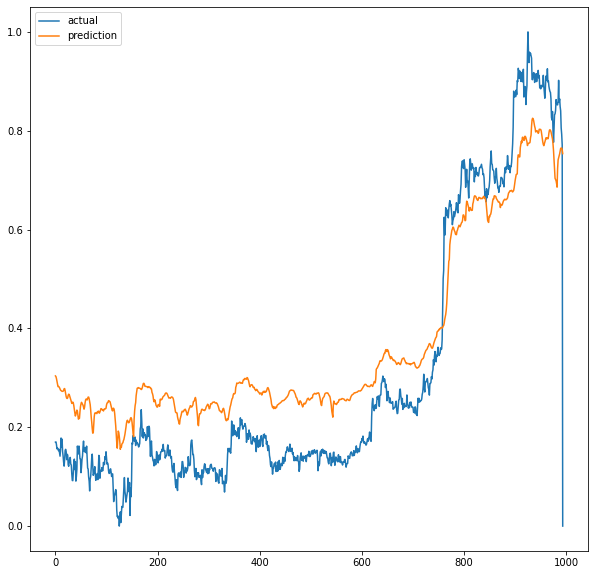

In [78]:
pred = lstm_model.predict(dataset)
actual = np.asarray(processed_data.label)[6:]

pred = pred[:, 0]

print(pred.shape)
print(actual.shape)

plt.figure(figsize=(10,10))
plt.plot(actual, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

# 오르는지 내리는지 평가

In [79]:
rate_pred = pred[-1]/pred[-2] 
# rate_pred = pred[-1]/actual[-2] 
print("이전 종가 : ", pred[-2])
# print("이전 종가 : ", actual[-2])
print("현재 예측 종가 : ", pred[-1])
print("비율 : ", rate_pred)
if rate_pred < 1 :
    print("Down")
else :
    print("Up")

이전 종가 :  0.76154023
현재 예측 종가 :  0.7537826
비율 :  0.9898132
Down


In [80]:
ticker = 'KRW-BTC'
interval ='minute10'
to = f'2021-11-10 00:20'
count = 2

test_up = pyupbit.get_ohlcv(ticker=ticker, interval=interval, to=to, count=count)
test_up


,open,high,low,close,volume,value
2021-11-10 00:00:00,80650000.0,80688000.0,80277000.0,80441000.0,167.911427,1.351430e+10
2021-11-10 00:10:00,80441000.0,81049000.0,80300000.0,80728000.0,112.802672,9.094108e+09


In [81]:
rate = test_up['close'][-1] / test_up['close'][-2]
print(rate)

if rate < 1 :
    print("Down")
else :
    print("Up")

1.0035678323243122
Up
